In [1]:
import pandas as pd
import glob
import os
from datetime import timedelta
import copy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "./ds/"
output_path = "./preprocessed/"

In [2]:
# gets user age group
def age_group(row):

    if row["age"] >= 0 and row["age"] <= 3:
        return "Bebek"
    elif row["age"] >= 4 and row["age"] <= 13:
        return "Çocuk"
    elif row["age"] >= 13 and row["age"] <= 20:
        return "Genç"
    else:
        return "Yetişkin"

# modification  
def modify_gender(row):
    if row["gender"] == "Bay":
        return "Erkek"
    return "Kadın"

# Read csvs and make first preprocessings

In [3]:
important_cols = set(["userid", "contentid", "partition_date", "currentbugroupname", "search_term"])

for file_name in os.listdir(path):
    if ".csv" in file_name:
       
       #drop dublicates while reading the csv since dublicate recors wont be useful
       df = pd.read_csv(f"{path}{file_name}").drop_duplicates()
       
       #I will ignore the records of which values are nan for the important_cols
       df_cols = set(list(df.columns.values))
       intersect = list(important_cols & df_cols)
       
       if len(intersect) > 0:
           df.dropna(subset=intersect, inplace=True)

       #if ["userid", "contentid", "partition_date"] in columns, drop dublicates for this subset (dataset shouldnt include more than one record for user-content-time triplets)

       if "userid" in df_cols and \
          "contentid" in df_cols and \
          "partition_date" in df_cols:
           df.drop_duplicates(subset=["userid", "contentid", "partition_date"], inplace=True)
       
       #eliminate the weird cases from datasets

       #eliminate rows if their quantity/price 0 or negative from purchased data
       if file_name == "df_basket.csv":
            df = df[df["addtobasket_count"]>0]

       elif file_name == "df_fav.csv":
            df = df[df["fav_count"]>0]

       elif file_name == "df_visit.csv":
            df = df[df["productdetailcount"]>0]

       elif file_name == "df_trx.csv":
            df = df[(df["quantity"]>0)&(df["price"]>0)]

       elif file_name == "df_demo.csv":
            df = df[df["age"]>0]
            df["age_group"] = df.apply(lambda x : age_group(x), axis = 1)
            df["gender"] = df.apply(lambda x : modify_gender(x), axis = 1)

       elif file_name == "df_product.csv":
            # Fill missing values with the most frequent element
            
            for col in ["age", "gender"]:    
               most_frequent = df[col].mode()[0]
               df[col] = df[col].fillna(most_frequent)
           
       print(file_name, df.shape[0])
       df.to_pickle(f'{output_path}{file_name}.pkl')








df_basket.csv 406268
df_demo.csv 25200
df_target_train.csv 24734
df_visit.csv 14389618
df_product.csv 1441753
df_search_term.csv 1281752
df_test.csv 244836
df_trx.csv 378938
df_fav.csv 733827


# Outlier analysis

df_visit.csv count_records extreme cases' distribution


count      800.000000
mean      3259.936250
std       1261.121491
min       2129.000000
25%       2399.750000
50%       2791.000000
75%       3716.000000
max      12047.000000
Name: count_records, dtype: float64

df_visit.csv count_records normal cases'  distribution


count    38008.000000
mean       309.978662
std        371.045929
min          1.000000
25%         58.000000
50%        171.000000
75%        417.000000
max       2128.000000
Name: count_records, dtype: float64

********************************************************


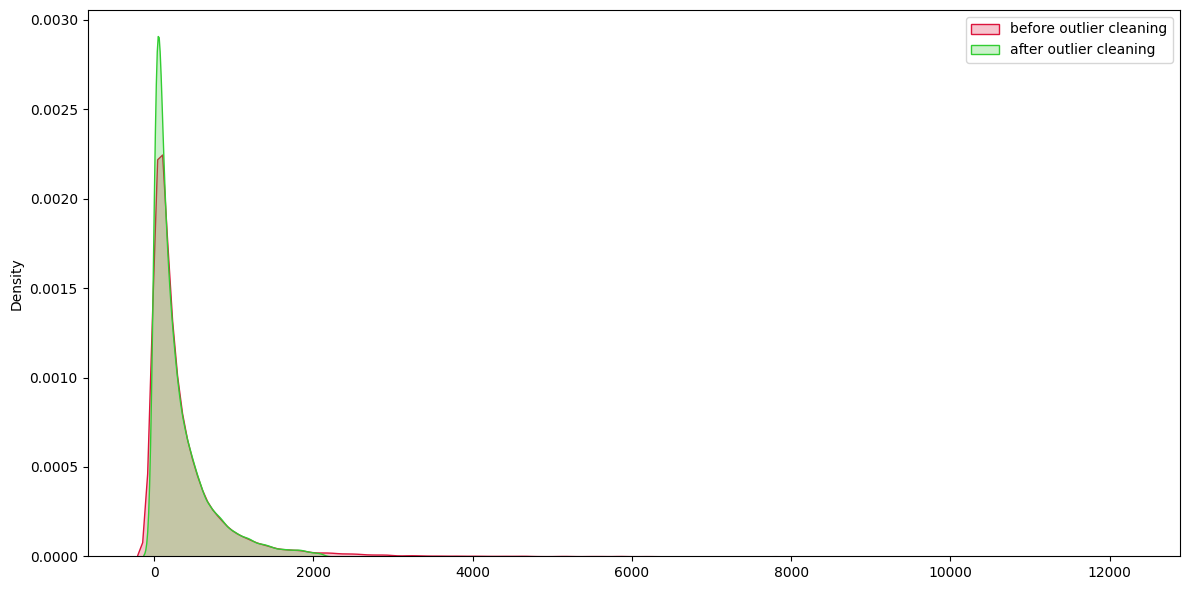

df_basket.csv count_records extreme cases' distribution


count    3173.000000
mean       17.090136
std        10.323736
min        11.000000
25%        12.000000
50%        14.000000
75%        18.000000
max       265.000000
Name: count_records, dtype: float64

df_basket.csv count_records normal cases'  distribution


count    179875.000000
mean          1.957142
std           1.611445
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          10.000000
Name: count_records, dtype: float64

********************************************************


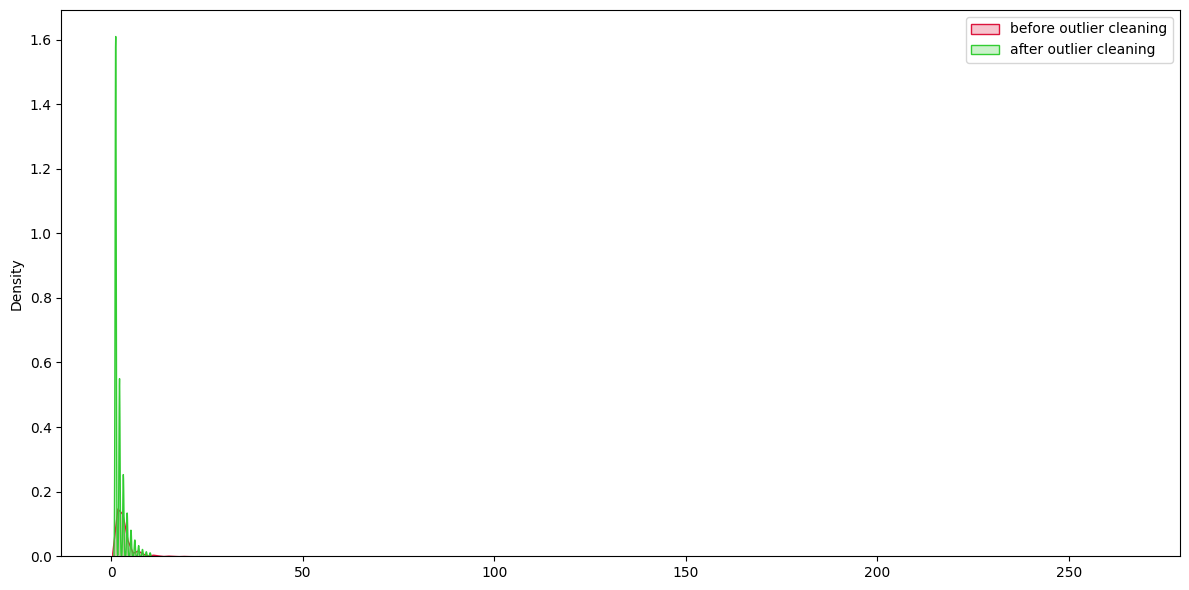

df_fav.csv count_records extreme cases' distribution


count     181.000000
mean      780.845304
std       598.472656
min       413.000000
25%       468.000000
50%       575.000000
75%       823.000000
max      3835.000000
Name: count_records, dtype: float64

df_fav.csv count_records normal cases'  distribution


count    14526.000000
mean        40.788517
std         60.278071
min          1.000000
25%          4.000000
50%         17.000000
75%         52.000000
max        412.000000
Name: count_records, dtype: float64

********************************************************


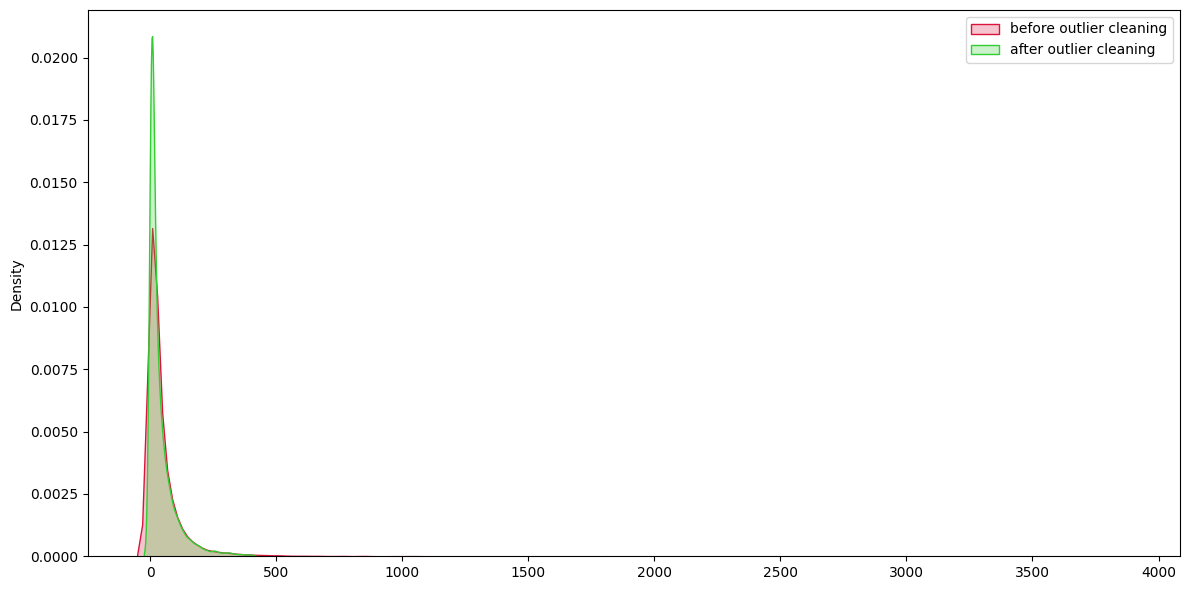

df_trx.csv count_records extreme cases' distribution


count      74.000000
mean      534.243243
std       772.600923
min       156.000000
25%       196.250000
50%       249.500000
75%       437.750000
max      3529.000000
Name: count_records, dtype: float64

df_trx.csv count_records normal cases'  distribution


count    30953.000000
mean        10.965141
std         15.427392
min          1.000000
25%          2.000000
50%          6.000000
75%         13.000000
max        155.000000
Name: count_records, dtype: float64

********************************************************


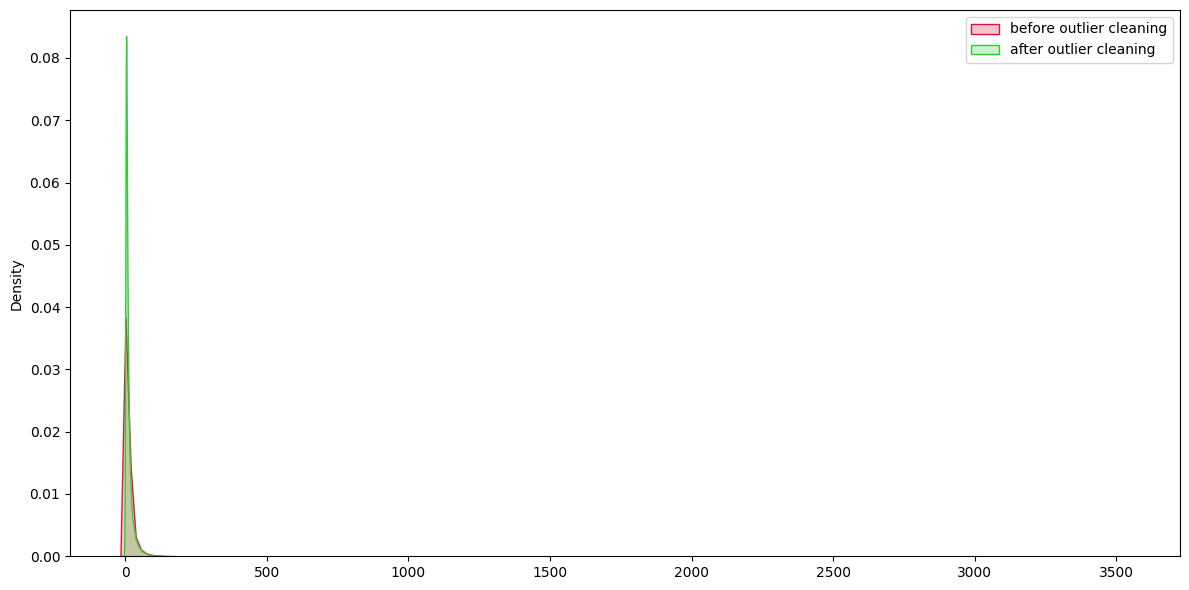

In [4]:
# for each events, calculate each users total records, avg interactions and avg price
for prefix, the_event in zip(["productdetailcount", "addtobasket_count", "fav_count", "quantity"],["df_visit.csv", "df_basket.csv", "df_fav.csv", "df_trx.csv"]):

    
    
    df_event = pd.read_pickle(f"{output_path}{the_event}.pkl")
    
    df_record = df_event.groupby(['userid']).size().reset_index(name=f'count_records')
    z_record = np.abs(stats.zscore(df_record["count_records"])) # calculate z-scores

    # lets check distributionaly different instances really extreme
    print(the_event, "count_records extreme cases' distribution")
    display(df_record[z_record > 3]["count_records"].describe())


    print(the_event, "count_records normal cases'  distribution")
    display(df_record[z_record <= 3]["count_records"].describe())

    print("********************************************************")

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=df_record["count_records"].values,
                color='crimson', label='before outlier cleaning', fill=True, ax=ax)
    sns.kdeplot(data=df_record[z_record <= 3]["count_records"].values,
                color='limegreen', label='after outlier cleaning', fill=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.show()




- According to outlier analysis, checking users' record counts seems to give succesful result to detect bot like users

    -- extreme users' and normal users' records counts really seem to have different distribution

# Lets eliminate extreme users and contentids that doesnt have currentbugroupname from all datasets

In [5]:
bot_users = []
# for each events, calculate each users total records, avg interactions and avg price
for prefix, the_event in zip(["productdetailcount", "addtobasket_count", "fav_count", "quantity"],["df_visit.csv", "df_basket.csv", "df_fav.csv", "df_trx.csv"]):

    
    
    df_event = pd.read_pickle(f"{output_path}{the_event}.pkl")
    
    df_record = df_event.groupby(['userid']).size().reset_index(name=f'count_records')
    z_record = np.abs(stats.zscore(df_record["count_records"])) # calculate z-scores

    #save extreme cases
    bot_users = bot_users + df_record[z_record > 3]['userid'].tolist()


df_product = pd.read_pickle(f"{output_path}df_product.csv.pkl")
pd_list = []

for file_name in os.listdir(output_path):
    if ".csv" in file_name and "df_product" not in file_name:
       
       #read preprocessed data
       df = pd.read_pickle(f"{output_path}{file_name}")

       #filter extreme users
       filtered_df = df[~(df["userid"].isin(bot_users))]

       print(file_name, filtered_df.shape[0])
       filtered_df.to_pickle(f'{output_path}{file_name}')


       if "df_trx.csv" in file_name:
            col = "orderdate"
       elif "df_visit.csv" in file_name or "df_basket.csv" in file_name or "df_fav.csv" in file_name:
            col = "partition_date"
       else:
            col = ""

       if col != "":
        #get the meta data infos for contentid and check if there is any dublication
        print("size before the left join",file_name, filtered_df.shape[0])
        df_event = pd.merge(filtered_df, df_product, how='left', on="contentid")
        print("size after the left join",file_name, df_event.shape[0])
        
        #I will ignore the records of which values are nan for the currentbugroupname col
        df_event.dropna(subset=['currentbugroupname'], inplace=True)


        #for make labelling more easy cast partition date to timestamp
        df_event["date"] = df_event[col].apply(lambda x: x[0:x.find(" ")])
        df_event["date"] = pd.to_datetime(df_event["date"])
            
        #finally check the shape
        print("latest size", file_name, df_event.shape)
        print("***************************************************************")
 
        df_event.to_pickle(f'{output_path}{file_name}')
        pd_list.append(df_event[["userid"]])

#filter train/test data from outlier user as well

userids = pd.concat(pd_list)
userids.drop_duplicates(keep="last", inplace=True)

for split_name in ["df_target_train.csv.pkl", "df_test.csv.pkl"]:
     
     the_data = pd.read_pickle(f"{output_path}{split_name}")
     the_data = the_data[the_data["userid"].isin(userids["userid"].tolist())]
     the_data.to_pickle(f'{output_path}{split_name}')
     
     print("latest size", split_name, the_data.shape)
     print("***************************************************************")


df_visit.csv.pkl 11584330
size before the left join df_visit.csv.pkl 11584330
size after the left join df_visit.csv.pkl 11584330
latest size df_visit.csv.pkl (8567033, 11)
***************************************************************
df_test.csv.pkl 238884
df_demo.csv.pkl 24337
df_trx.csv.pkl 297290
size before the left join df_trx.csv.pkl 297290
size after the left join df_trx.csv.pkl 297290
latest size df_trx.csv.pkl (228011, 12)
***************************************************************
df_fav.csv.pkl 531406
size before the left join df_fav.csv.pkl 531406
size after the left join df_fav.csv.pkl 531406
latest size df_fav.csv.pkl (398720, 11)
***************************************************************
df_basket.csv.pkl 351665
size before the left join df_basket.csv.pkl 351665
size after the left join df_basket.csv.pkl 351665
latest size df_basket.csv.pkl (283442, 11)
***************************************************************
df_target_train.csv.pkl 23744
df_search_term

# Fast check to see whether important features contains nan
## Result : everything seems to ok

In [6]:
for file_name in os.listdir(output_path):
    if ".csv" in file_name:
       
       #read preprocessed data
       df = pd.read_pickle(f"{output_path}{file_name}")

       print(file_name)
       display(df.isnull().sum())
       print("******************************************************************")

df_visit.csv.pkl


userid                   0
contentid                0
partition_date           0
productdetailcount       0
currentbugroupname       0
brandid                  0
gender                   0
age                      0
title                 1756
categoryname             0
date                     0
dtype: int64

******************************************************************
df_test.csv.pkl


userid                     0
currentbugroupname         0
probability           230592
target                230592
dtype: int64

******************************************************************
df_demo.csv.pkl


userid       0
gender       0
age          0
tenure       0
age_group    0
dtype: int64

******************************************************************
df_trx.csv.pkl


userid                 0
contentid              0
orderdate              0
quantity               0
price                  0
currentbugroupname     0
brandid                0
gender                 0
age                    0
title                 29
categoryname           0
date                   0
dtype: int64

******************************************************************
df_fav.csv.pkl


userid                 0
contentid              0
partition_date         0
fav_count              0
currentbugroupname     0
brandid                0
gender                 0
age                    0
title                 97
categoryname           0
date                   0
dtype: int64

******************************************************************
df_basket.csv.pkl


userid                 0
contentid              0
partition_date         0
addtobasket_count      0
currentbugroupname     0
brandid                0
gender                 0
age                    0
title                 45
categoryname           0
date                   0
dtype: int64

******************************************************************
df_target_train.csv.pkl


userid                0
currentbugroupname    0
dtype: int64

******************************************************************
df_product.csv.pkl


contentid               0
currentbugroupname      0
brandid                 0
gender                  0
age                     0
title                 588
categoryname            0
dtype: int64

******************************************************************
df_search_term.csv.pkl


userid            0
partition_date    0
search_term       0
dtype: int64

******************************************************************
